# <span style="font-weight: bold;">계층적 군집화 (Hierarchical clustering)</span>

## <span style="font-weight: bold;"> 1.라이브러리 로드</span>

In [18]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(action="ignore")

# 데이터 정규화 패키지
from sklearn.preprocessing import StandardScaler

# 군집분석 관련 패키지
from sklearn import cluster
from sklearn import mixture
from sklearn import datasets
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


# 차원축소를 위한 패키지
from sklearn.decomposition import PCA

# 유사도 측정 관련 패키지
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

# 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt

# 그래프의 style을 'seaborn-whitegrid'로 설정
plt.style.use(["seaborn-whitegrid"])

# 마이너스 기호(-) 깨짐 방지
matplotlib.rcParams["axes.unicode_minus"] = False

# 한글 폰트 사용하기
plt.rc("font", family="Malgun Gothic")

## <span style="font-weight: bold;"> 2.군집화 예시</span>

### <span style="font-weight: bold;"> 2.1 랜덤 데이터 생성</span>

In [19]:
# 데이터를 무작위로 생성
np.random.seed(0)
n_samples = 1500
random_state = 0
noise = 0.05

### <span style="font-weight: bold;"> 2.2 산점도 시각화 함수</span>

In [20]:
# 2차원 평면공간에 주어진 dataset에 대한 산점도를 시각화하는 함수
def plot_data(dataset, position, title):
    X, y = dataset  # 2차원 배열로 X는 데이터 포인트에 대한 튜플, y는 label
    plt.subplot(position)  # 매개변수 position 자리에 오는 argument의 위치에 subplot을 그림
    plt.title(title)  # plot의 제목을 매개변수 title 자리에 오는 argument로 설정
    plt.scatter(X[:, 0], X[:, 1])  # 2개의 X변수를 사용하여 산점도를 시각화

### <span style="font-weight: bold;"> 2.3 다양한 형태의 군집화</span>

In [21]:
# 다양한 형태의 군집화 결과
circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=noise, random_state=random_state
)  # factor는 내부와 외부 원의 크기 비율을 설정하는 파라미터
moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
no_structures = np.random.rand(n_samples, 2), None

### <span style="font-weight: bold;"> 2.4 결과 시각화</span>

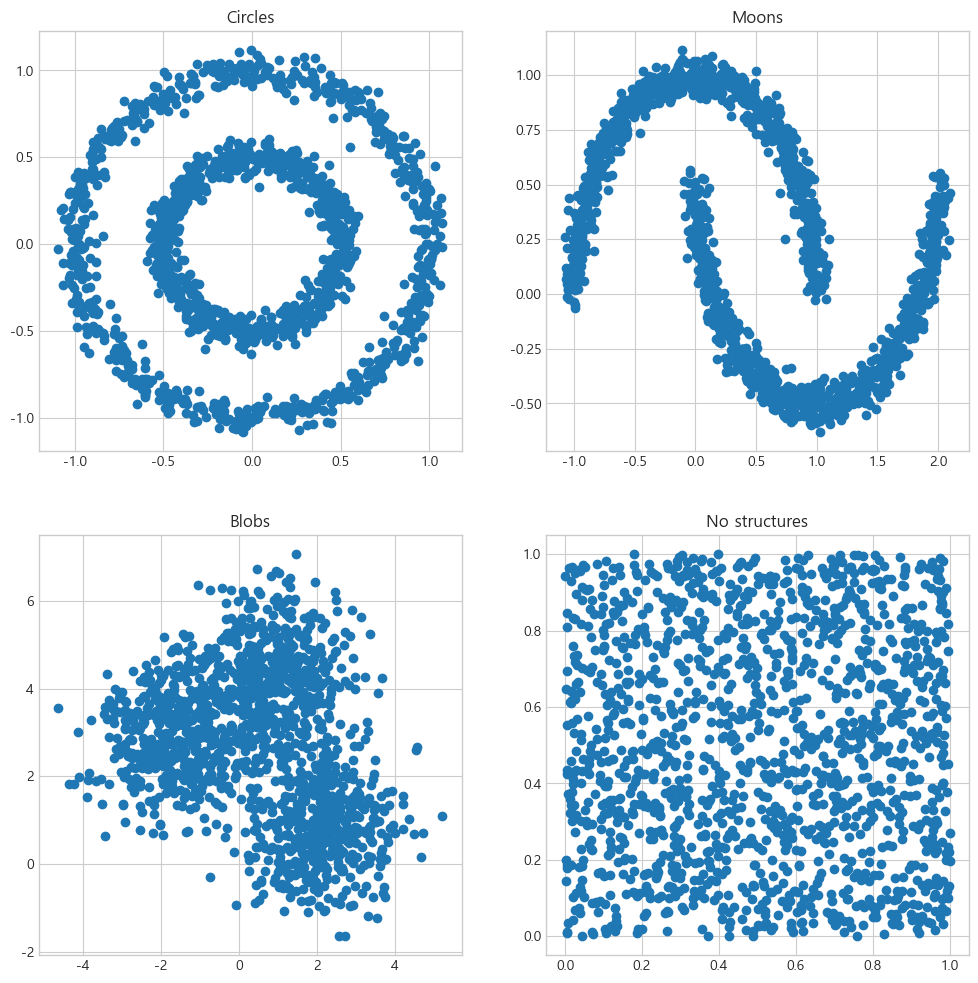

In [22]:
plt.figure(figsize=(12, 12))
plot_data(circles, 221, "Circles")
plot_data(moons, 222, "Moons")
plot_data(blobs, 223, "Blobs")
plot_data(no_structures, 224, "No structures")

In [23]:
# argument에 주어진 모델을 사용하여 데이터셋에 대해 군집화를 수행하는 함수
def fit_predict_plot(model, dataset, position, title):
    X, y = dataset
    model.fit(X)  # 모델을 사용하여 데이터 X에 대해 학습을 수행
    if hasattr(model, "labels_"):  # 모델이 labels_ 속성을 가지고 있는지 확인
        labels = model.labels_.astype(int)
    else:
        labels = model.predict(X)

    colors = np.array(
        [
            "#30A9DE",
            "#E53A40",
            "#090707",
            "#A593E0",
            "#F6B352",
            "#519D9E",
            "#D81159",
            "#8CD790",
            "#353866",
        ]
    )
    ax = plt.subplot(position)
    ax.set_title(title)
    ax.scatter(X[:, 0], X[:, 1], color=colors[labels])

## <span style="font-weight: bold;"> 3.계층적 군집화 (Hierarchical clustering)</span>

### <span style="font-weight: bold;"> 3.1 계층적 군집화</span>
- <span style="font-weight: bold;"> 데이터의 군집을 계층적인 구조로 구성하는 방법으로, 덴드로그램(dendrogram)이라고 불리는 트리 형태를 조직화하여 군집을 형성</span>Agglomerative Hierarchical Clustering
- <span style="font-weight: bold;"> Agglomerative Hierarchical Clustering은 개별적인 데이터 포인트를 자체 클러스터로 간주하여, 가장 가까운 두 클러스터를 반복적으로 병합하여 단일 클러스터가 될 때까지 반복</span>

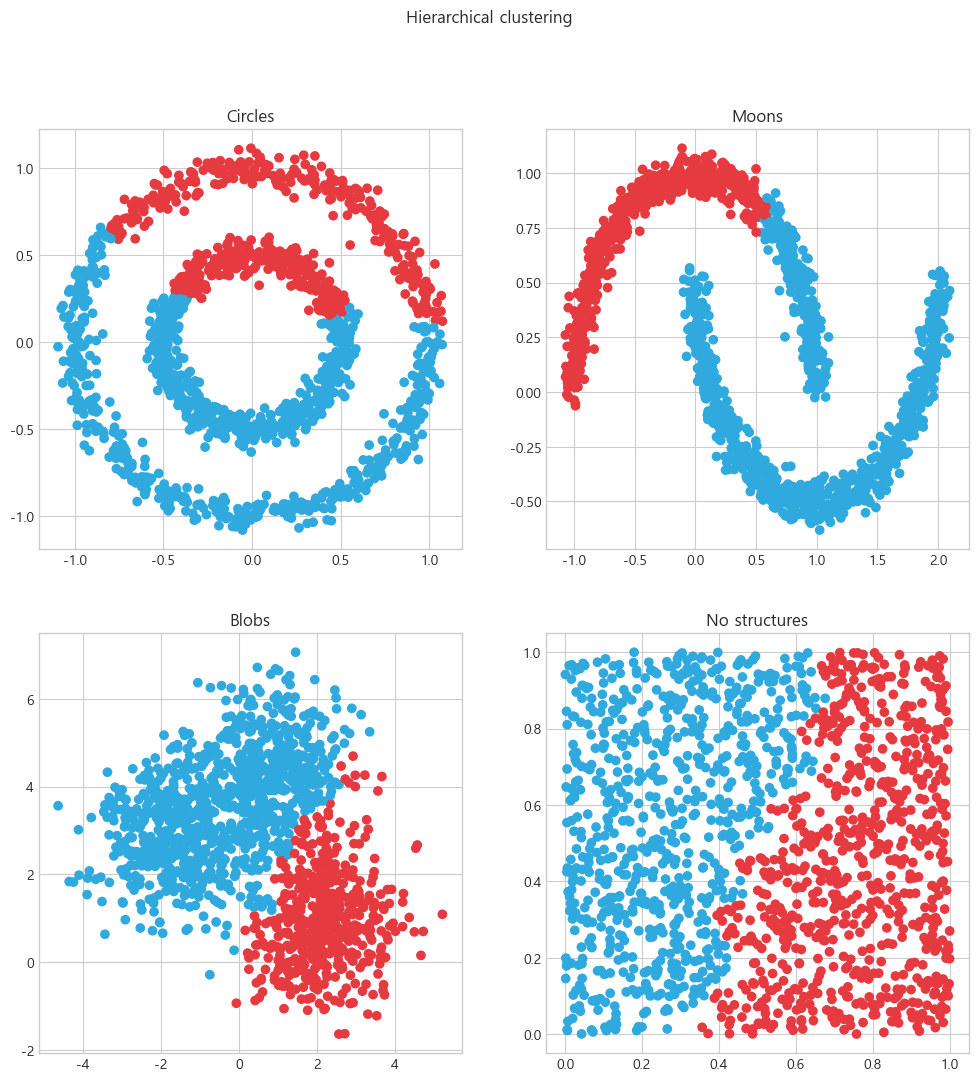

In [24]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Hierarchical clustering")

fit_predict_plot(
    cluster.AgglomerativeClustering(n_clusters=2, linkage="ward"),
    circles,
    221,
    "Circles",
)
fit_predict_plot(
    cluster.AgglomerativeClustering(n_clusters=2, linkage="ward"), moons, 222, "Moons"
)
fit_predict_plot(
    cluster.AgglomerativeClustering(n_clusters=2, linkage="ward"), blobs, 223, "Blobs"
)
fit_predict_plot(
    cluster.AgglomerativeClustering(n_clusters=2, linkage="ward"),
    no_structures,
    224,
    "No structures",
)

## <span style="font-weight: bold;"> 4.Hierarchical clustering (실습<1>)</span>

### <span style="font-weight: bold;">4-1. 데이터셋 설명(Wine dataset)</span>
- 13개의 연속형 X변수
- 1개의 카테고리형 Y변수 (3개 클래스 / 군집분석 시 사용하지 않음)

### <span style="font-weight: bold;">4-2. 데이터 셋 확인 </span>

In [25]:
# 와인 데이터셋 로드
wine_df = pd.read_csv("../Data/wine_data.csv")
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [26]:
# 데이터 스케일링 (표준화)
X = wine_df.iloc[:, :-1]
y = wine_df.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# AgglomerativeClustering 모델 생성 및 학습
model = AgglomerativeClustering(n_clusters=3)  # 3개의 클러스터로 설정
model.fit(X_scaled)  # 표준화된 데이터를 사용하여 모델 학습

# 예측한 클러스터 레이블 추출
predict = model.labels_

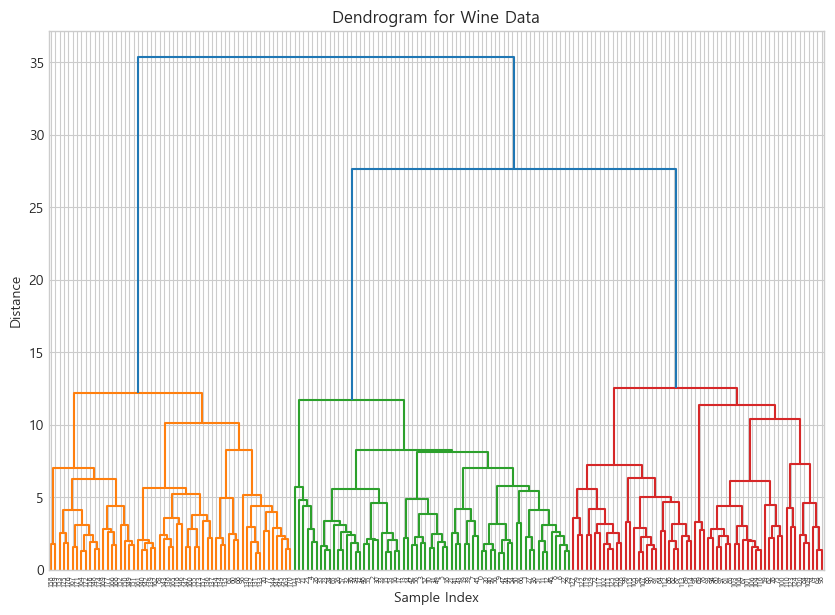

In [28]:
# 덴드로그램 생성
plt.figure(figsize=(10, 7))
Z = linkage(X_scaled, method="ward")
dendrogram(Z)
plt.title("Dendrogram for Wine Data")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

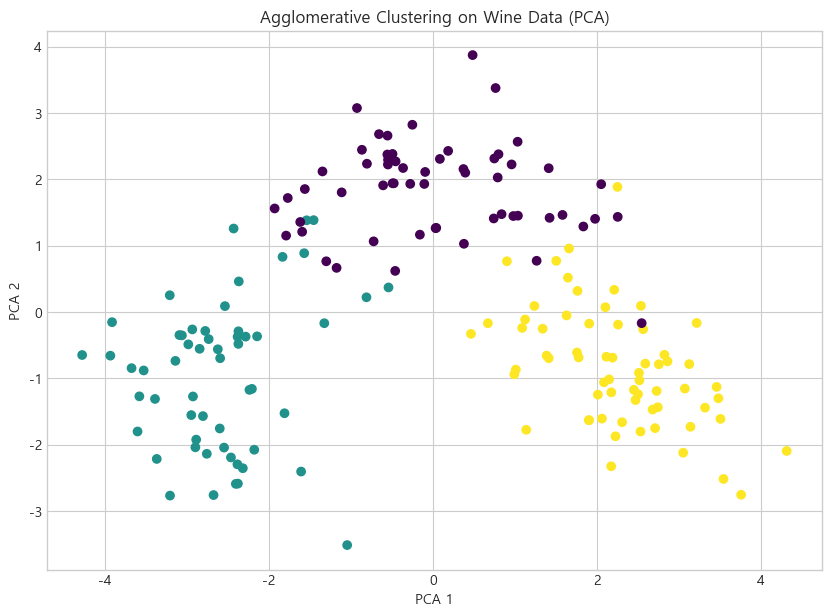

In [29]:
# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict, cmap="viridis")
plt.title("Agglomerative Clustering on Wine Data (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

## <span style="font-weight: bold;"> 5.Hierarchical clustering (실습<2>)</span>

### <span style="font-weight: bold;">5-1. 데이터셋 설명(Iris dataset)</span>
- 4개의 X변수(꽃받침 길이, 꽃받침 너비, 꽃잎 길이, 꽃잎 너비)을 포함하며, 150개의 샘플(데이터 포인트)
- 1개의 카테고리형 Y변수 (3개 클래스 / 군집분석 시 사용하지 않음)

### <span style="font-weight: bold;">5-2. 데이터 셋 확인 </span>

In [30]:
# 붓꽃 데이터셋 로드
iris_df = pd.read_csv("../Data/iris_data.csv")
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [31]:
# 데이터 스케일링 (표준화)
X = iris_df.iloc[:, :-1]
y = iris_df.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
# AgglomerativeClustering 모델 생성 및 학습
model = AgglomerativeClustering(n_clusters=3)  # 3개의 클러스터로 설정
model.fit(X_scaled)  # 표준화된 데이터를 사용하여 모델 학습

# 예측한 클러스터 레이블 추출
predict = model.labels_

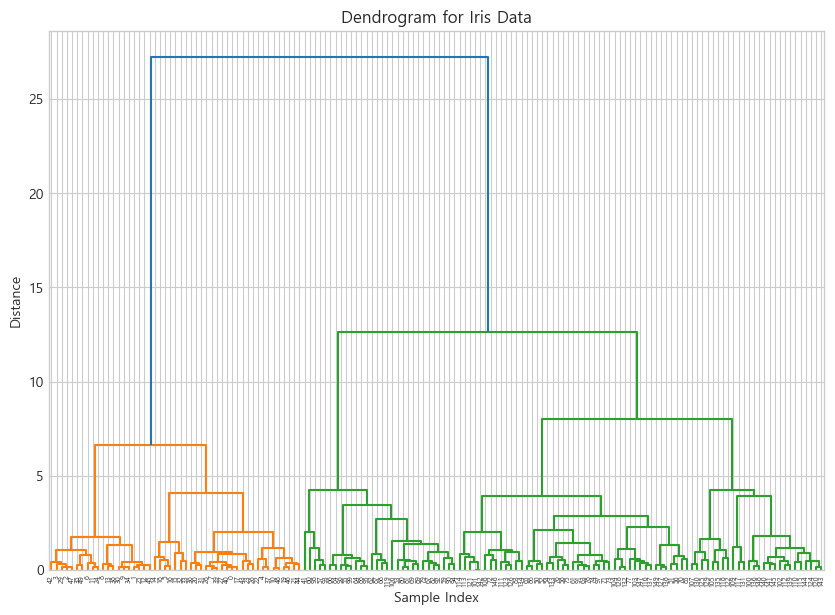

In [33]:
# 덴드로그램 생성
plt.figure(figsize=(10, 7))
Z = linkage(X_scaled, method="ward")
dendrogram(Z)
plt.title("Dendrogram for Iris Data")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

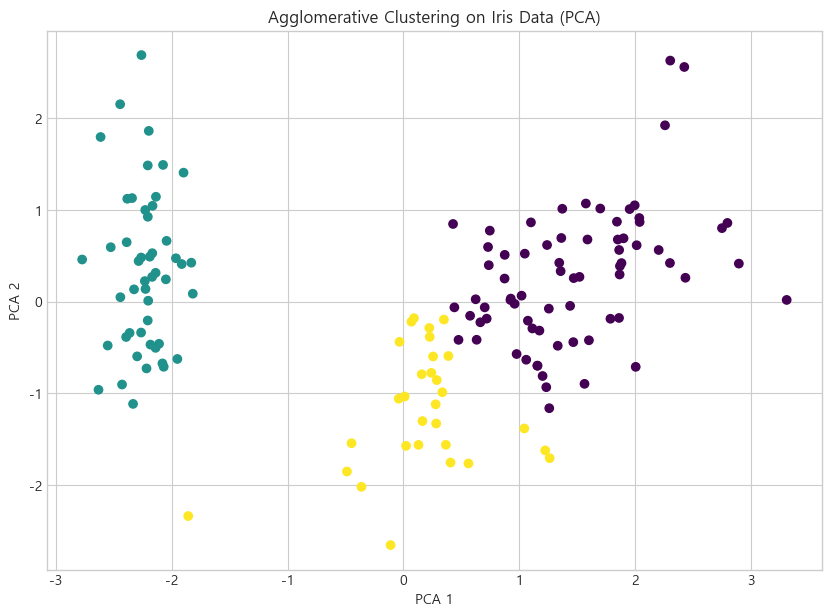

In [34]:
# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict, cmap="viridis")
plt.title("Agglomerative Clustering on Iris Data (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()